In [1]:
import collections
collections.Iterable = collections.abc.Iterable
from prepare_model_env import *

In [2]:
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import keras

In [4]:
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [5]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [6]:
# load dataset
dataset = Dataset(dataset_dir="../../datasets/marine_debris_detection/marine_debris-semantic_segmentation/dataset/", augmentation=get_training_augmentation())

D:\anaconda\envs\segmentation_gpu\lib\site-packages\albumentations\augmentations\transforms.py:2029: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  warnings.warn('Using lambda is incompatible with multiprocessing. '


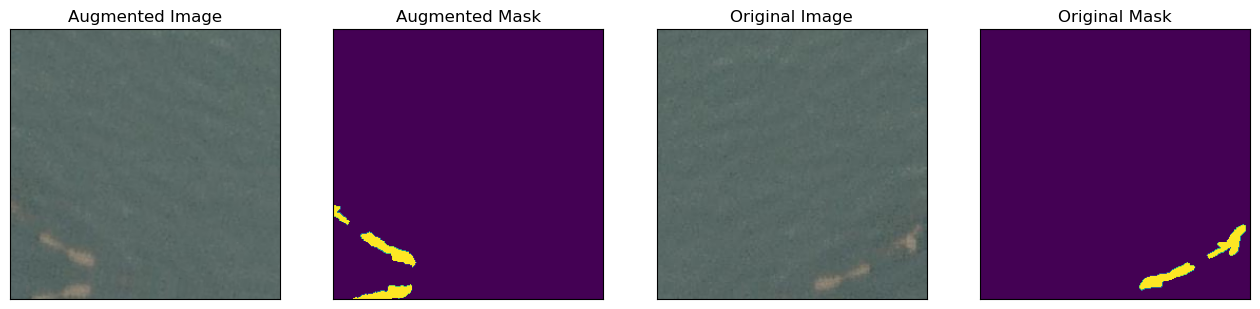

In [7]:
image, mask = dataset[120] # get some sample
visualize(
    augmented_image=image,
    augmented_mask=mask,
    original_image= dataset.x[120],
    original_mask= dataset.y[120]
)

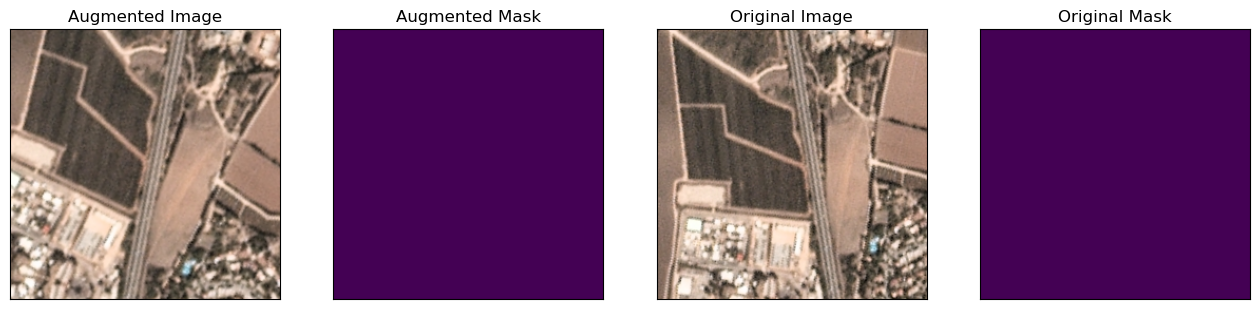

In [8]:
image, mask = dataset[260] # get some sample
visualize(
    augmented_image=image,
    augmented_mask=mask,
    original_image= dataset.x[260],
    original_mask= dataset.y[260]
)

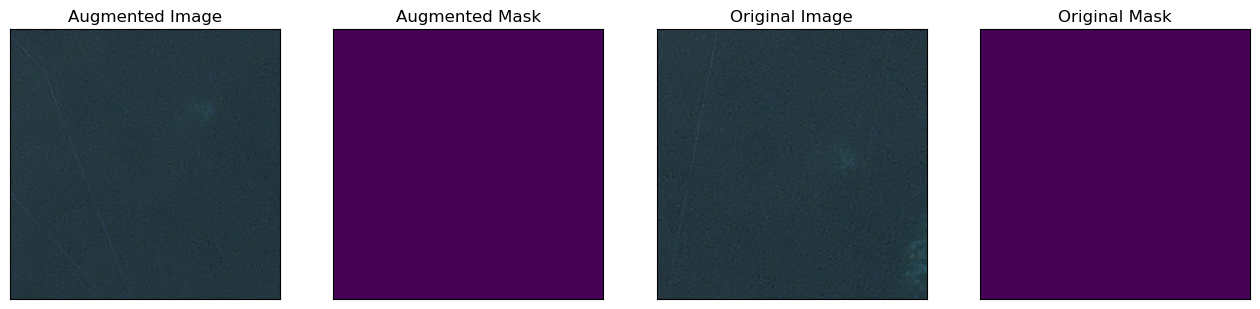

In [9]:
image, mask = dataset[250] # get some sample
visualize(
    augmented_image=image,
    augmented_mask=mask,
    original_image= dataset.x[250],
    original_mask= dataset.y[250]
)

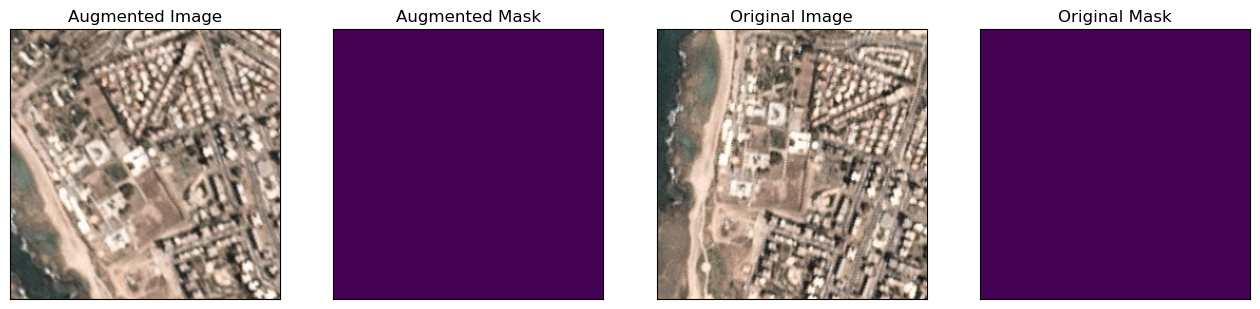

In [10]:
image, mask = dataset[240] # get some sample
visualize(
    augmented_image=image,
    augmented_mask=mask,
    original_image= dataset.x[240],
    original_mask= dataset.y[240]
)

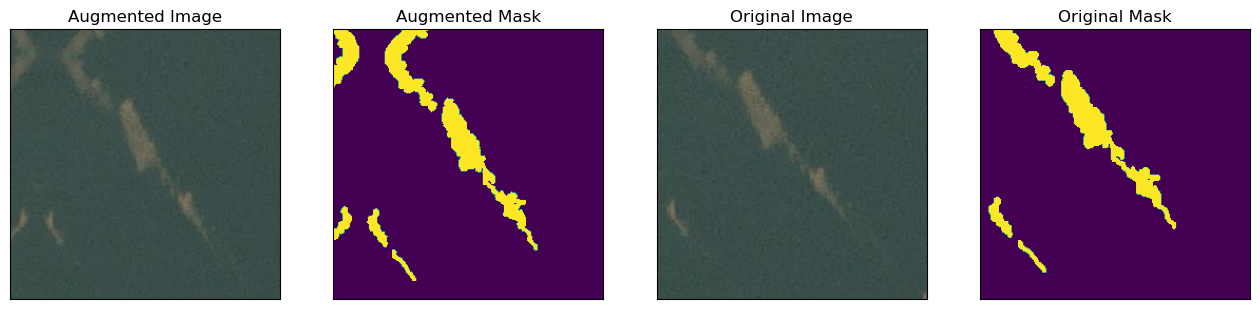

In [11]:
image, mask = dataset[180] # get some sample
visualize(
    augmented_image=image,
    augmented_mask=mask,
    original_image= dataset.x[180],
    original_mask= dataset.y[180]
)

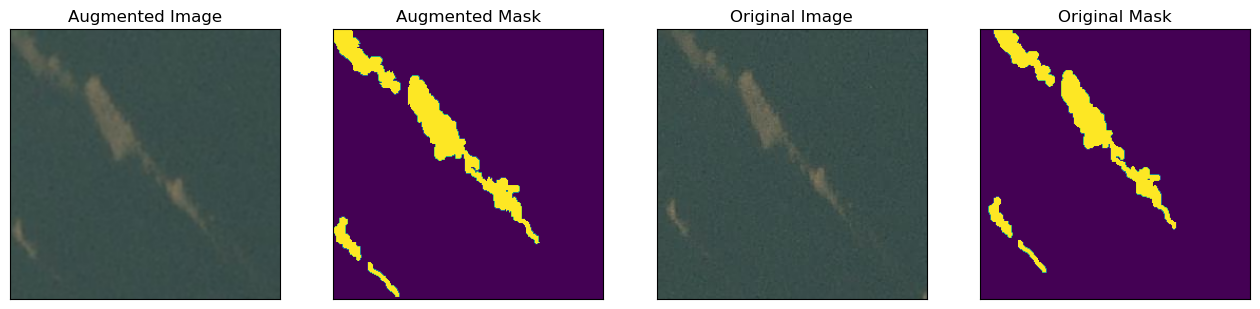

In [12]:
image, mask = dataset[180] # get some sample
visualize(
    augmented_image=image,
    augmented_mask=mask,
    original_image= dataset.x[180],
    original_mask= dataset.y[180]
)

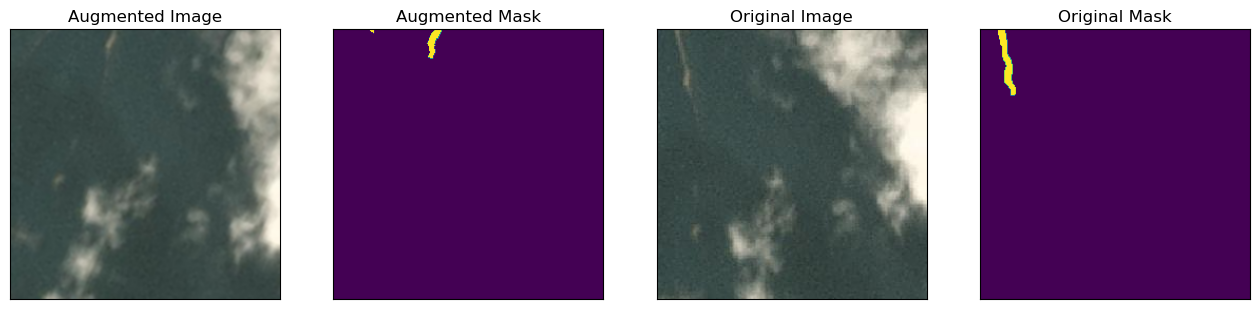

In [13]:
image, mask = dataset[190] # get some sample
visualize(
    augmented_image=image,
    augmented_mask=mask,
    original_image= dataset.x[190],
    original_mask= dataset.y[190]
)

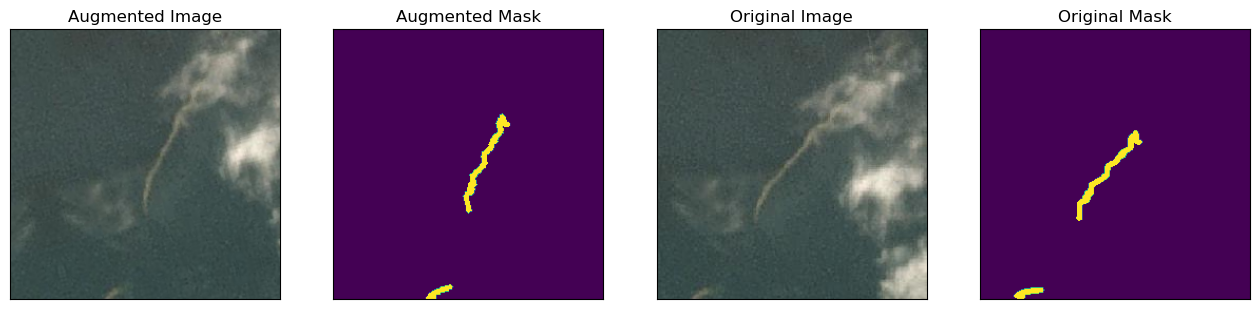

In [14]:
image, mask = dataset[191] # get some sample
visualize(
    augmented_image=image,
    augmented_mask=mask,
    original_image= dataset.x[191],
    original_mask= dataset.y[191]
)

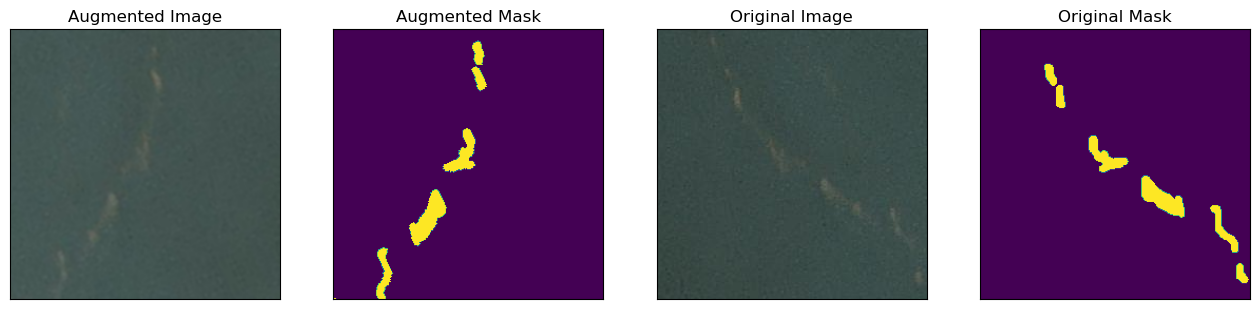

In [15]:
image, mask = dataset[195] # get some sample
visualize(
    augmented_image=image,
    augmented_mask=mask,
    original_image= dataset.x[195],
    original_mask= dataset.y[195]
)

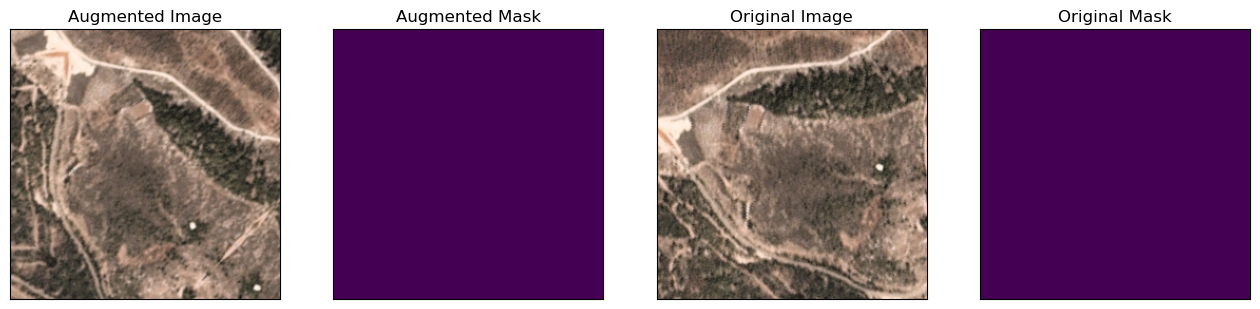

In [16]:
image, mask = dataset[210] # get some sample
visualize(
    augmented_image=image,
    augmented_mask=mask,
    original_image= dataset.x[210],
    original_mask= dataset.y[210]
)

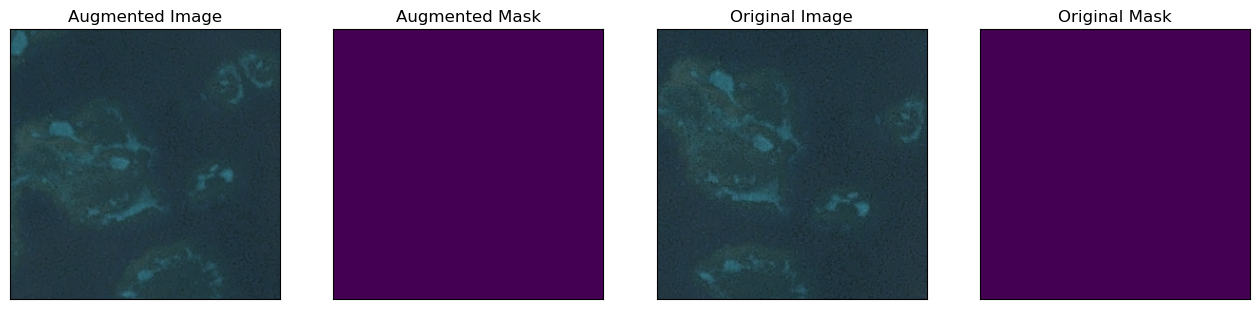

In [17]:
image, mask = dataset[230] # get some sample
visualize(
    augmented_image=image,
    augmented_mask=mask,
    original_image= dataset.x[230],
    original_mask= dataset.y[230]
)

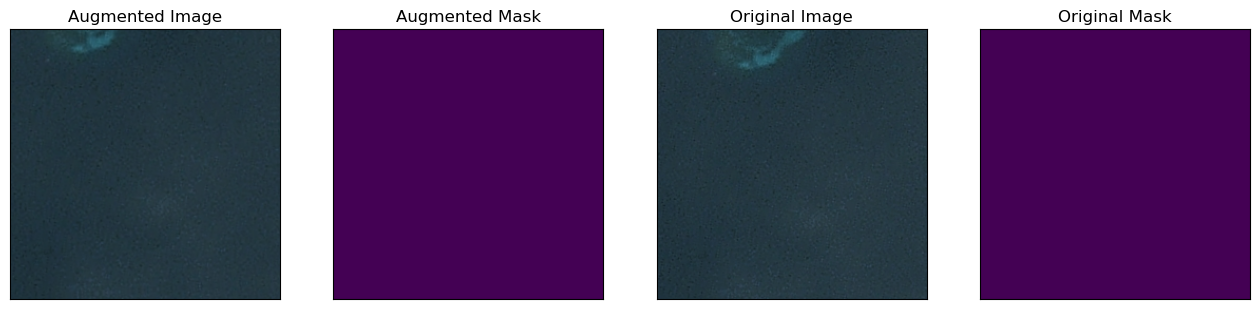

In [18]:
image, mask = dataset[231] # get some sample
visualize(
    augmented_image=image,
    augmented_mask=mask,
    original_image= dataset.x[231],
    original_mask= dataset.y[231]
)

In [19]:
with tf.device('/GPU:0'):
    BACKBONE = 'efficientnetb4'
    BATCH_SIZE = 4
    EPOCHS = 40
    LR = 0.0001

    # define optomizer
    optim = keras.optimizers.Adam(LR)

    preprocess_input = sm.get_preprocessing(BACKBONE)
    # define network parameters
    n_classes = 1
    activation = 'sigmoid'

    #create model
    model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)
    # dice loss = 1 - (2 * intersection) / (union + intersection)
    dice_loss = sm.losses.DiceLoss()
    # Binary Focal Loss = -α * (1 - p)^γ * log(p) - (1 - α) * p^γ * log(1 - p)
    # α is a weighting factor to balance the contribution of the two classes. It is typically set to the inverse of the class frequencies.
    # p is the predicted probability of the positive class.
    # γ is the focusing parameter that controls how much the loss is focused on hard examples.
    # When γ = 0, the focal loss becomes the standard binary cross-entropy loss. As γ increases,
    # the loss focuses more on hard examples, i.e., examples that are misclassified with high confidence.
    focal_loss = sm.losses.BinaryFocalLoss(gamma=2.8, alpha=0.6)

    total_loss = dice_loss + 1.5*focal_loss

    metrics = [sm.metrics.IOUScore(threshold=0.8)]

    # compile keras model with defined optimozer, loss and metrics
    model.compile(optim, loss=total_loss, metrics=metrics)
    # define callbacks for learning rate scheduling and best checkpoints saving
    callbacks = [
        keras.callbacks.ModelCheckpoint('./best_model_efficientnetb4_3.h5', save_weights_only=True, save_best_only=True, mode='min', monitor="val_loss"),
        keras.callbacks.ReduceLROnPlateau(),
    ]
    #tf.config.run_functions_eagerly(True)

In [20]:
tf.config.run_functions_eagerly(False)
model.load_weights("best_model_efficientnetb4_2.h5")

In [21]:
with tf.device('/GPU:0'):
    # train test split
    x_train, x_val, y_train, y_val = dataset.split_data()

    # pre processing
    x_train, y_train, x_val, y_val = dataset.pre_process(x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val)

    # define dataloader and datasets objects for train and validation data
    train_dataset = Dataset(
        x=x_train,
        y=y_train,
        augmentation=get_training_augmentation(),
        #preprocessing=get_preprocessing(preprocess_input)
    )

    valid_dataset = Dataset(
        x=x_val,
        y=y_val,
        augmentation=get_training_augmentation(),
        #preprocessing=get_preprocessing(preprocess_input)
    )

In [22]:
train_data_generator = Dataloader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, generate=4)
valid_data_generator = Dataloader(valid_dataset, batch_size=1, shuffle=False, generate=2)

In [23]:
len(train_data_generator.dataset.x)

1075

In [24]:
len(valid_data_generator.dataset.x)

162

In [25]:
with tf.device('/GPU:0'):
    history = model.fit(
        x=train_data_generator.dataset.x,
        y=train_data_generator.dataset.y,
        shuffle=train_data_generator.shuffle,
        batch_size=train_data_generator.batch_size,
        callbacks=callbacks,
        epochs=EPOCHS,
        validation_data=(valid_data_generator.dataset.x, valid_data_generator.dataset.y),
    )

Epoch 1/40
269/269 [==============================] - 91s 214ms/step - loss: 0.0948 - iou_score: 0.8591 - val_loss: 0.2826 - val_iou_score: 0.6005 - lr: 1.0000e-04
Epoch 2/40
269/269 [==============================] - 50s 187ms/step - loss: 0.0937 - iou_score: 0.8603 - val_loss: 0.2843 - val_iou_score: 0.5971 - lr: 1.0000e-04
Epoch 3/40
269/269 [==============================] - 50s 188ms/step - loss: 0.0887 - iou_score: 0.8670 - val_loss: 0.3003 - val_iou_score: 0.5749 - lr: 1.0000e-04
Epoch 4/40
269/269 [==============================] - 52s 194ms/step - loss: 0.0879 - iou_score: 0.8675 - val_loss: 0.2821 - val_iou_score: 0.6016 - lr: 1.0000e-04
Epoch 5/40
269/269 [==============================] - 51s 191ms/step - loss: 0.0896 - iou_score: 0.8668 - val_loss: 0.2950 - val_iou_score: 0.5867 - lr: 1.0000e-04
Epoch 6/40
269/269 [==============================] - 51s 190ms/step - loss: 0.0855 - iou_score: 0.8703 - val_loss: 0.2801 - val_iou_score: 0.6046 - lr: 1.0000e-04
Epoch 7/40
269/2

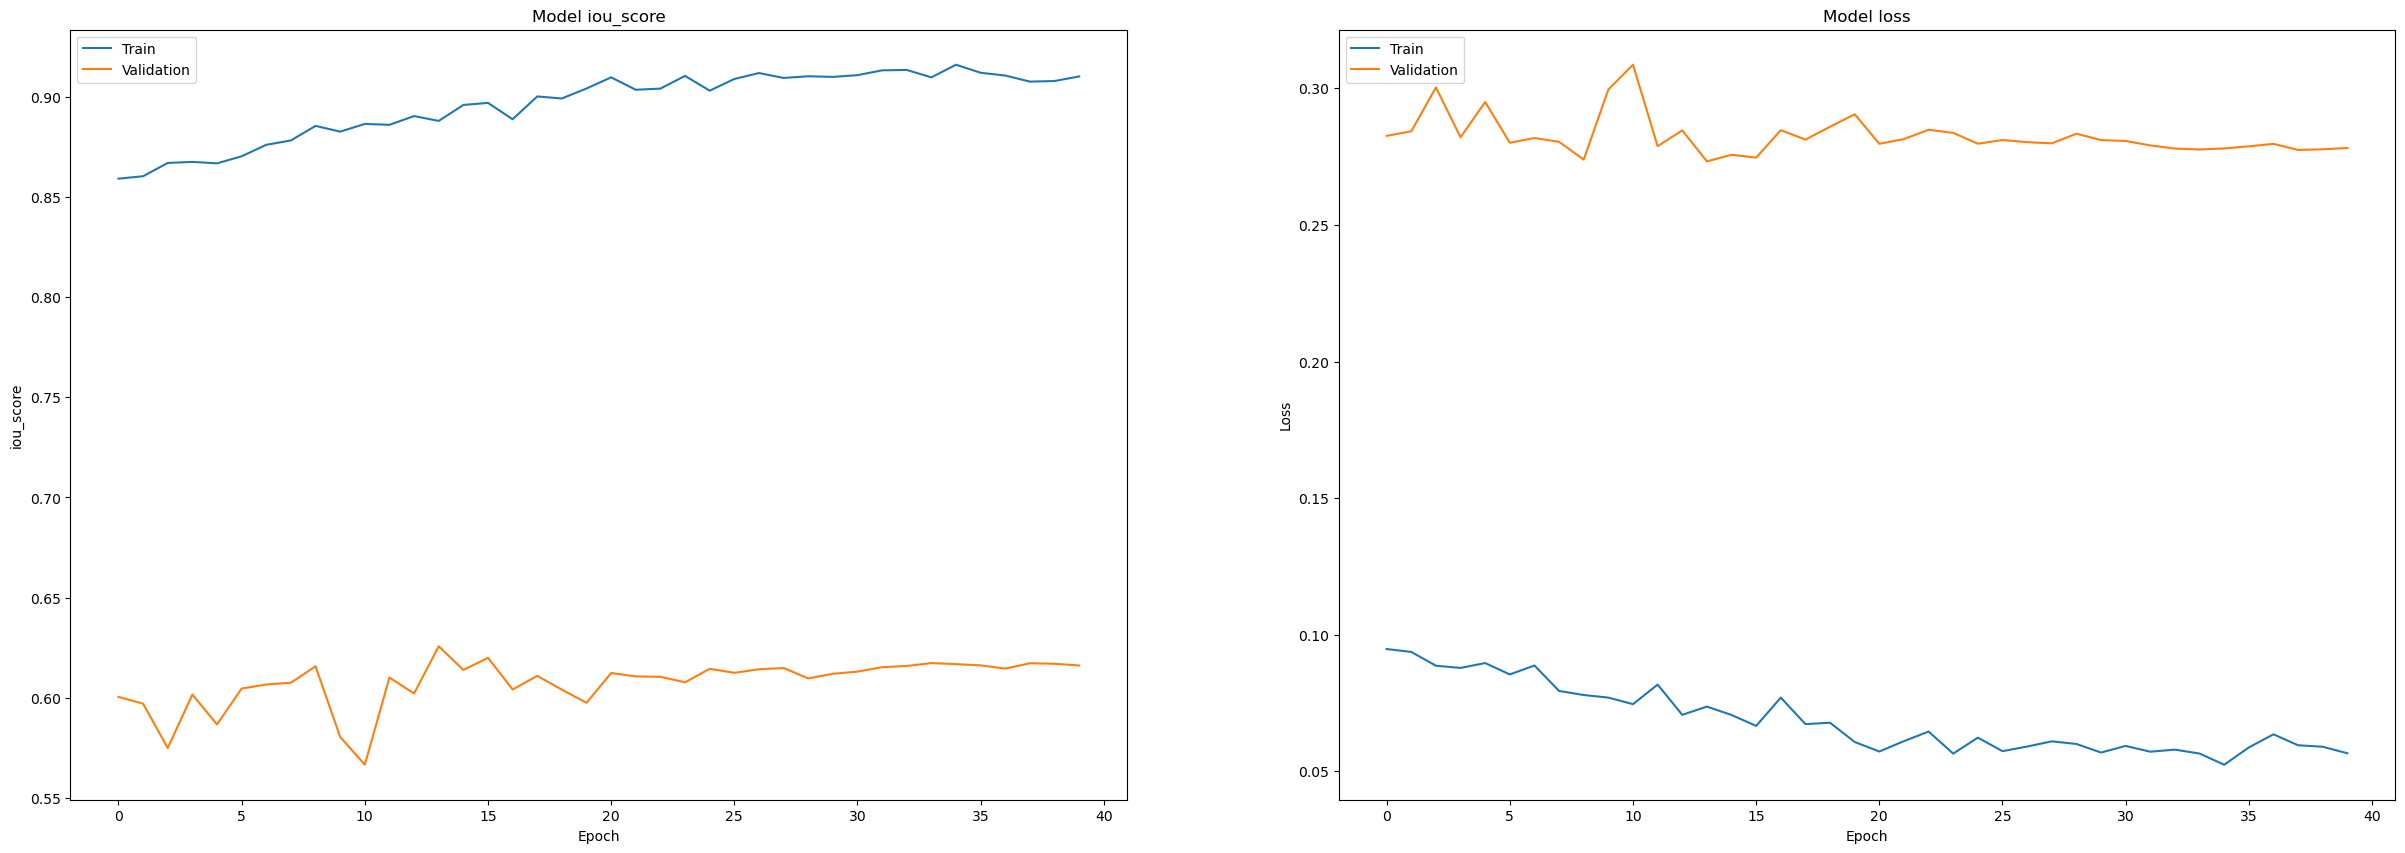

In [26]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 10))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()